<a href="https://colab.research.google.com/github/samharrison16/TROCAIRE/blob/main/Kivu_AGB_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Modelling aboveground biomass in Kivu, Rwanda for the TROCAIRE project
Random forest regression model implemented in google earth engine using the Google Earth Engine Python API.

Input data processed in Earth Engine and stored as Earth Engine assets 

In [198]:
import ee
#ee.Authenticate()
#ee.Initialize()

In [199]:
path = "projects/trocaire-sh/assets/KV"
Cband = ee.Image(path + "_Cband")
Lband = ee.Image(path + "_PALSAR")
optical = ee.Image(path + "_optical")
soil_pca = ee.Image(path + "_soil_pc")
topo = ee.Image(path + "_topo")
worldclim = ee.Image(path + "_worldclim")
all = optical.addBands(Cband).addBands(Lband).addBands(soil_pca).addBands(topo).addBands(worldclim)
table = ee.FeatureCollection(path+"_agb").filter(ee.Filter.neq('PLOT_ID',64))

inputs = ee.List([
  "clim_pc1",
  "clim_pc2",
  "clim_pc3",
  "soil_pc1",
  "soil_pc2",
  "soil_pc3",
  "mTPI",
  "B2",
  "B3",
  "B4",
  "B8",
  "VH",
  "VV",
  "VH_range",
  "HV",
  "HH",
  'HH_HV',
  "B4_stdDev",
  "B8_stdDev"
])


all = all.select(inputs)

geometry = ee.Geometry.Polygon(
        [[[29.352, -2.385],
          [29.352, -2.665],
          [29.552, -2.665],
          [29.552, -2.385]]])

#set seed and define the percentage data hold back for testing
seed = 10
splitpc = 0.75

In [200]:
#Buffer plot points by the size of the plot
def buffer (feature):
    return ee.Feature(feature.buffer(ee.Number(feature.get('PLOT_ha')).divide(3.14159265358979323846264).sqrt().multiply(100)))
ground_data = table.map(buffer)  

# split the data randomly to hold back data for testing, stratified so the same percentage split is taken across cover types 
def sortit (cover_n):
    cov = ground_data.filter(ee.Filter.equals('PLOT_ha', cover_n)).randomColumn('random', seed)
    cov = cov.sort('random')
    def srt(num):
      feature = ee.Feature(cov.toList(cov.size()).get(num))
      return feature.set('sorted', ee.Number(num).add(1))
    alist = (ee.List.sequence(0, cov.size().subtract(1), 1))
    alist = alist.map(srt)
    return ee.FeatureCollection(alist)

def train (cover_n):
    split = ee.Number(sortit(cover_n).size()).multiply(ee.Number(splitpc))
    ltsplit = sortit(cover_n)
    ltsplit = ltsplit.filter(ee.Filter.lte('sorted', split))
    return ltsplit

trainingPartition = train(0.5).merge(train(1))

def test (cover_n):
    split = ee.Number(sortit(cover_n).size()).multiply(ee.Number(splitpc))
    gtsplit = sortit(cover_n)
    gtsplit = gtsplit.filter(ee.Filter.gt('sorted', split))
    return gtsplit

testingPartition = test(0.5).merge(test(1))

In [201]:
#sample the pixels for the plots
training = all.reduceRegions(**{
    'collection': trainingPartition,
    'reducer': ee.Reducer.mean(),
    'scale': 20
  })

bands = all.bandNames()


In [202]:
#find the best variables per split parameter for the random forest regression model
def varsplit (split):
  init_params = {"numberOfTrees":150,
              "variablesPerSplit":split, 
               "seed":seed}
  trained = ee.Classifier.smileRandomForest(**init_params).train(training, 'AGB_ha', inputs).setOutputMode('REGRESSION')
  classifierexplain = trained.explain()
  return ee.Number(classifierexplain.get('outOfBagErrorEstimate'))
a = ee.List.sequence(2, ee.List(inputs).size(), 1).map(varsplit)
b = ee.List.sequence(2, ee.List(inputs).size(), 1)
bestsplit = b.get(a.indexOf(a.reduce(ee.Reducer.min())))
bestsplit.getInfo()

17

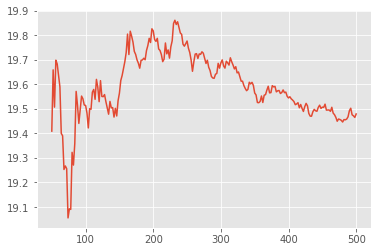

In [219]:
from matplotlib import pyplot as plt

#find the best number of trees parameter for the random forest regression model
def treeno (trees):
  trained = ee.Classifier.smileRandomForest(**{
      'numberOfTrees': trees,
      'variablesPerSplit': bestsplit,
      'seed': seed
    }).train(training, 'AGB_ha', inputs).setOutputMode('REGRESSION')
  classifierexplain = trained.explain()
  return ee.Number(classifierexplain.get('outOfBagErrorEstimate'))

c = ee.List.sequence(50, 500, 2).map(treeno)
d = ee.List.sequence(50, 500, 2)
besttrees = (d.get(c.indexOf(c.reduce(ee.Reducer.min()))))
besttrees.getInfo()

#scree plot all model OOBs against trees 
plt.plot(d.getInfo(), c.getInfo())

In [204]:
trainedcluster = ee.Classifier.smileRandomForest(besttrees,bestsplit).train(training, 'AGB_ha', bands).setOutputMode('REGRESSION');

classified = all.classify(trainedcluster)

In [205]:
#get the predicted values of the testing plots
testing = classified.reduceRegions(**{ 
    'collection': testingPartition,
    'reducer': ee.Reducer.mean(),
    'scale': 20
  })

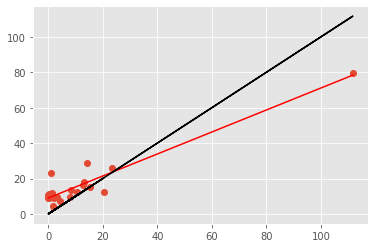

In [206]:
import numpy as np
import pandas as pd

#plot the modelled values against the measured values for the testing data
a = [d['properties'] for d in testing.getInfo()['features']]
AGB = [d['AGB_ha'] for d in a]
pred = [d['mean'] for d in a]
validation = pd.DataFrame({'AGB': AGB, 'pred': pred})
plt.plot(AGB, pred, 'o')
plt.plot(np.unique(AGB), np.poly1d(np.polyfit(AGB, pred, 1))(np.unique(AGB)), '-r')
plt.plot(AGB, AGB, '-k')
plt.show()

In [207]:
from sklearn.metrics import mean_squared_error, r2_score

#stats for the testing plots
rmse = mean_squared_error(AGB, pred, squared=False)
r2 = r2_score(AGB, pred)
print(rmse)
print(r2)

11.114594676383463
0.781465154799485


In [ ]:
import folium

# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# Set visualisation parameters.
vis_params = {
  'min': 0,
  'max': 100,
  'palette': ['d8d8d8','23de20','00ba17']}

# Create a folium map object.
my_map = folium.Map(location=[-2.5, 29.45], zoom_start=10)

# Add the elevation model to the map object.
my_map.add_ee_layer(classified, vis_params, 'DEM')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the agb map.
display(my_map)

         band         value
2          B4  7.547790e+03
3   B4_stdDev  1.169612e+04
6          HH  1.784919e+04
0          B2  1.929002e+04
11         VV  1.965164e+04
16       ndvi  2.016733e+04
4          B8  2.199135e+04
5   B8_stdDev  2.906731e+04
17        pc1  3.401232e+04
9          VH  4.201764e+04
1          B3  4.687833e+04
13      bio04  4.966017e+04
19        pc3  6.711395e+04
18        pc2  8.112223e+04
10   VH_range  2.456599e+05
8          HV  2.466624e+05
7       HH_HV  3.191437e+05
12      bio01  3.914913e+05
14      bio12  8.639873e+05
15      bio15  1.391640e+06


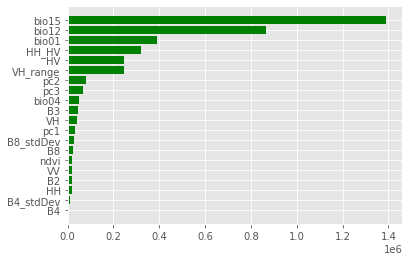

In [195]:
#get the importance values from the RF model (Gini impurity)
d = trainedcluster.explain().get('importance').getInfo()
imp = pd.DataFrame(d.items()).rename(columns={0: "band", 1: "value"})
imp = imp.sort_values(by='value')
plt.clf()
plt.style.use('ggplot')
print(imp)
x = imp.band
y = imp.value

plt.barh(x, y, color='green')

plt.show()


In [ ]:
# export the agb image
task = ee.batch.Export.image.toDrive(**{
  'image': classified,
  'description':'KV_AGB',
  'folder': 'TROCAIRE',
  'region': geometry,
  'scale': 20
  })
task.start()

In [ ]:
import time
while task.active():
  print('Polling for task (id: {}).'.format(task.id))
  time.sleep(5)

In [ ]:
# export testing data
task2 = ee.batch.Export.table.toDrive(**{
  'collection': testing,
  'description':'KV_AGB_test',
  'fileFormat': 'csv',
  'folder': 'TROCAIRE'
})
#task2.start()

In [ ]:
while task2.active():
  print('Polling for task (id: {}).'.format(task2.id))
  time.sleep(5)